In [141]:
!pip install missingno

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [142]:
import pandas as pd
import numpy as np
import missingno as msn

In [ ]:
df_2023 = pd.read_csv('../data/raw_data/uk_2023.csv', encoding='iso-8859-2', delimiter=';')
df_2022 = pd.read_csv('../data/raw_data/uk_2022.csv', encoding='iso-8859-2', delimiter=';')
df_2021 = pd.read_csv('../data/raw_data/uk_2021.csv', encoding='iso-8859-2', delimiter=';')

In [ ]:
result = pd.concat([df_2023, df_2022, df_2021], axis=0, ignore_index=True)

In [ ]:
result['colour_rating_new'] = result['colour_rating'].combine_first(result['colour_rating.1'])


In [ ]:
result = result.drop(columns=['colour_rating', 'colour_rating.1'])

In [ ]:
result

# Cleaning text from columns

In [ ]:
result['wlc_baseline_incl_NCG'] = result['wlc_baseline_incl_NCG'].str.replace('Ł', '', regex=False)
result['total_baseline'] = result['total_baseline'].str.replace('Ł', '', regex=False)
result['forecast_incl_NGC'] = result['forecast_incl_NGC'].str.replace('Ł', '', regex=False)
result['yearly_forecast'] = result['yearly_forecast'].str.replace('Ł', '', regex=False)
result['TOTAL Baseline Benefits (Łm)'] = result['TOTAL Baseline Benefits (Łm)'].str.replace('Ł', '', regex=False)

## Loop for cleaning many columns at once

In [ ]:
# Definiere eine Funktion, die den gesamten Prozess für eine Zelle übernimmt
def process_value(value):
    # Erster Schritt: Versuchen, in eine Zahl zu konvertieren
    try:
        float(value)
        return value
    except ValueError:
        pass
    
    # Zweiter Schritt: Ersetze ',' durch '' und versuche erneut, in eine Zahl zu konvertieren
    try:
        value = value.replace(',', '')
        float(value)
        return value
    except (ValueError, AttributeError):
        return np.nan

# Wende die Funktion auf mehrere Spalten gleichzeitig an
columns_to_process = ['total_baseline', 'forecast_incl_NGC', 'wlc_baseline_incl_NCG', 'TOTAL Baseline Benefits (Łm)', 'yearly_forecast']
result[columns_to_process] = result[columns_to_process].applymap(process_value)

# Zeige das Ergebnis an
print(result)


In [ ]:
unique_texts = result[result['wlc_baseline_incl_NCG'].apply(is_text)]['wlc_baseline_incl_NCG'].unique()

print(unique_texts)

# Further cleaning

In [ ]:
result['start_date'] = pd.to_datetime(result['start_date'], errors='coerce')

In [ ]:
result['end_date'] = pd.to_datetime(result['end_date'], errors='coerce')

In [ ]:
result['forecast_incl_NGC'] = pd.to_numeric(result['forecast_incl_NGC'], errors='coerce')
result['wlc_baseline_incl_NCG'] = pd.to_numeric(result['wlc_baseline_incl_NCG'], errors='coerce')
result['yearly_forecast'] = pd.to_numeric(result['yearly_forecast'], errors='coerce')
result['TOTAL Baseline Benefits (Łm)'] = pd.to_numeric(result['TOTAL Baseline Benefits (Łm)'], errors='coerce')
result['total_baseline'] = pd.to_numeric(result['total_baseline'], errors='coerce')

In [ ]:
result['colour_rating_new'].unique()

In [ ]:
allowed_values = ['Amber', 'Green', 'Red', 'Amber/red', 'Amber/Green']
result['colour_rating_new'] = result['colour_rating_new'].apply(lambda x: x if x in allowed_values else np.nan)

In [ ]:
result['colour_rating_new'].unique()

In [ ]:
result = result.rename(columns={'colour_rating_new': 'colour_rating'})

In [ ]:
result['yearly_budget'] = np.nan

In [ ]:
result['yearly_forecast_new'] = result['yearly_forecast'].combine_first(result['forecast_incl_NGC'])

In [ ]:
result.columns

In [ ]:
result = result.drop(columns=['yearly_forecast', 'forecast_incl_NGC'])

In [ ]:
result = result.rename(columns={'yearly_forecast_new': 'yearly_forecast'})

In [ ]:
result.columns

In [ ]:
result = result.drop(columns=['yearly_budget'])

In [ ]:
result = result.rename(columns={'total_baseline': 'yearly_budget'})
result = result.rename(columns={'TOTAL Baseline Benefits (Łm)': 'total_benefits'})

In [ ]:
column_order = ['project_name','department','colour_rating','description_aims','rating_comment','start_date','end_date','schedule_comment','yearly_budget','yearly_forecast','wlc_baseline_incl_NCG','variance_comment','budget_comment','year','report_category','project_number','total_benefits','benefits_comment']

In [ ]:
result = result[column_order]

In [ ]:
result.columns

In [ ]:
result.info()

In [ ]:
result.to_csv('../data/raw_data/2021_2023.csv')

In [ ]:
result.to_pickle("cleaned_2021_2023.pkl")

In [ ]:
df_rauschgold = pd.read_csv('../data/raw_data/2021_2023.csv')
df_emna = pd.read_csv('df_2014_2017.csv')

In [ ]:
result = pd.concat([df_rauschgold, df_emna], axis=0, ignore_index=True)

In [ ]:
result.columns

In [ ]:
result = result.drop(columns=['Unnamed: 0'])

In [ ]:
result.to_csv('emna_franzi.csv')

In [ ]:
df1 = pd.read_csv('../data/raw_data/2021_2023.csv')
df2 = pd.read_csv('../data/raw_data/df_2014_2017.csv')
df3= pd.read_csv('../data/raw_data/uk_2018-2020.csv')

In [ ]:
result = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [ ]:
result = result.drop(columns=['Unnamed: 0'])

In [ ]:
result.to_csv('dataset_EDA.csv')

In [ ]:
df

In [ ]:
df_macro = pd.read_csv('../data/macro/GDP.csv',encoding='iso-8859-2', delimiter=';')

In [ ]:
df_macro

In [ ]:
df_macro.info()

In [ ]:
df_franzi = pd.read_csv('../data/EDA/2021_2023.csv')

In [ ]:
import re

# Funktion zur Extraktion von Datumsangaben im Format '01 April 2024', '30 MAR 2023', oder '30 MAR  2023'
def extract_dates_for_end_date(comment):
    # Muster zur Erkennung von Datumsformaten wie '01 April 2024', '30 MAR 2023', '30 MAR  2023'
    date_pattern = r'\d{2} \w+ {1,2}\d{4}'
    dates = re.findall(date_pattern, comment)
    return dates

# Fehlende Daten in 'end_date' ergänzen
for index, row in df_franzi.iterrows():
    dates = extract_dates_for_end_date(row['schedule_comment'])
    
    if pd.isna(row['end_date']) and dates:
        # Nur das erste gefundene Datum wird verwendet
        converted_date = convert_date(dates[0])
        if converted_date:
            df_franzi.at[index, 'end_date'] = converted_date

# Ergebnis anzeigen
df_franzi



In [ ]:
# Schritt 1: Identifizieren der relevanten Zeilen
remained_scheduled_df = df_franzi[df_franzi['schedule_comment'].str.contains('remained scheduled', case=False)]

# Schritt 2: Aktuellsten 'end_date'-Wert für jedes 'project_name' ermitteln
latest_end_dates = df_franzi.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'end_date'])

# Schritt 3: Zuweisen des aktuellsten 'end_date' an die relevanten Zeilen
for index, row in remained_scheduled_df.iterrows():
    latest_end_date = latest_end_dates[row['project_name']]
    if pd.isna(row['end_date']) and pd.notna(latest_end_date):
        df_franzi.at[index, 'end_date'] = latest_end_date

# Ergebnis anzeigen
df_franzi


In [ ]:
# Schritt 2: Aktuellsten 'end_date'-Wert für jedes 'project_name' ermitteln
latest_end_dates = df_franzi.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'start_date'])

# Schritt 3: Zuweisen des aktuellsten 'end_date' an die relevanten Zeilen
for index, row in remained_scheduled_df.iterrows():
    latest_end_date = latest_end_dates[row['project_name']]
    if pd.isna(row['start_date']) and pd.notna(latest_end_date):
        df_franzi.at[index, 'start_date'] = latest_end_date

# Ergebnis anzeigen
df_franzi

In [ ]:
    month_mapping = {
        'jan': '01', 'january': '01',
        'feb': '02', 'february': '02',
        'mar': '03', 'march': '03',
        'apr': '04', 'april': '04',
        'may': '05', 'may': '05',
        'jun': '06', 'june': '06',
        'jul': '07', 'july': '07',
        'aug': '08', 'august': '08',
        'sep': '09', 'september': '09',
        'oct': '10', 'october': '10',
        'nov': '11', 'november': '11',
        'dec': '12', 'december': '12'
    }



In [ ]:
def extract_date_after_to_or_on(comment):
    REGEX = "(to|is|on)\s*(\d{1,2})\s+(\w+)\s+(\d{2,4})"
    x = re.compile(REGEX)
    
    match_REGEX = x.search(comment)      
    
    if match_REGEX:
        day = match_REGEX.group(2)
        month = match_REGEX.group(3)
        year = match_REGEX.group(4)
        if len(day) == 1:
            day = '0'+ day
        month = month_mapping.get(month.lower())
        if len(year) == 2:
            year = '20' + year
        return year +'-'+ month +'-'+ day
    
for index, row in df_franzi.iterrows():
    if pd.isna(row['end_date']):
        extracted_date = extract_date_after_to_or_on(row['schedule_comment'])
        if extracted_date:
            df_franzi.at[index, 'end_date'] = extracted_date

df_franzi



In [ ]:
df_franzi.drop(columns='Unnamed: 0')

In [ ]:
df_franzi.to_pickle("cleaned_2021_2023.pkl")

In [ ]:
# Der Code zum Filtern von Zeilen, in denen 'start_date' oder 'end_date' 'NaN' ist
# und die 'schedule_comment' nicht mit 'Exempt' oder '\r\nExempt' beginnen

nan_dates_df = df_franzi[
    ((df_franzi['end_date'].isna())) & 
    (~df_franzi['schedule_comment'].str.match(r'^(Exempt|\r\nExempt)'))
][['start_date', 'end_date', 'schedule_comment']]

# Ausgabe des gefilterten DataFrames
nan_dates_df

In [ ]:
# Der Code zum Filtern von Zeilen, in denen 'start_date' oder 'end_date' 'NaN' ist
# und die 'schedule_comment' nicht mit 'Exempt' oder '\r\nExempt' beginnen

nan_dates_df_start = df_franzi[
    ((df_franzi['start_date'].isna())) & 
    (~df_franzi['schedule_comment'].str.match(r'^(Exempt|\r\nExempt)'))
][['start_date', 'schedule_comment']]

# Ausgabe des gefilterten DataFrames
nan_dates_df_start

In [ ]:
len(nan_dates_df)
nan_dates_df['schedule_comment'].to_list()

In [ ]:
merged_df = df_franzi.merge(df_macro, on='year', how='left')

In [ ]:
merged_df

In [171]:
df1 = pd.read_pickle("../data/pickle/cleaned_2021_2023.pkl")
df2 = pd.read_pickle('../data/pickle/cleaned_2018_2020.pkl')
df3 = pd.read_pickle('../data/pickle/cleaned_2014-2017.pkl')
df4 = pd.read_csv('../data/macro/GDP.csv',encoding='iso-8859-2', delimiter=';')

In [172]:
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [173]:
df = df.merge(df4, on='year', how='left')

In [174]:
df.drop(columns='Unnamed: 0')

,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,...,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,Civil Service Pensions 2015 Remedy,CO,Amber,The 2015 Pensions Remedy Programme was created...,"Compared to financial year 21/22-Q4, the Deliv...",2020-05-20,2024-09-30,"Compared to financial year 21/22-Q4, the proje...",7.90,4.20,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
1,Commercial Capability Expansion Programme,CO,Amber,The original Commercial Capability Programme s...,"Compared to financial year 21/22-Q4, the Seni...",2017-04-01,2023-03-31,"Compared to financial year 21/22-Q4, the proje...",3.70,3.10,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
2,Falcon IT Platform Refresh and Migration,CO,Amber,Falcon is a business change programme that wil...,The Senior Responsible Owner's Delivery Confid...,2022-05-01,2025-03-31,The project's end-date at 22/23-Q4 is 2025-03-...,0.00,0.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
3,Future Service Programme,CO,Amber,Future Services Programme is a series of procu...,"Compared to financial year 21/22-Q4, the Deliv...",2020-10-01,2025-12-31,"Compared to financial year 21/22-Q4, the proje...",1.60,1.70,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
4,GOV.UK One Login,CO,Amber,GOV.UK One Login will provide a single account...,"Compared to financial year 21/22-Q4, the Infra...",2021-01-04,2025-03-31,"Compared to financial year 21/22-Q4, the proje...",114.00,114.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,IT Transformation Programme,NCA,Amber,IT Transformation is one of three programmes t...,The IPA Review Team made 7 recommendations whe...,2016-04-01 00:00:00,2022-07-31 00:00:00,Schedule on track,14.00,14.00,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1726,NCA Transformation Programme,NCA,Amber,The NCAÂs Transformation Programme which will...,The current status of the NCA Transformation P...,2014-04-01 00:00:00,2019-03-31 00:00:00,Schedule on track,25.50,25.50,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1727,Census Transformation Programme,ONS,Amber,The Census Transformation Programme will run f...,1. ONS requires greater clarity from HMT on th...,2015-01-01 00:00:00,2025-03-31 00:00:00,Tranche 1 focussing on 2017 Test on schedule. ...,36.03,36.03,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1728,Unnamed: 144,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
df.to_pickle("cleaned_2014_2023.pkl")

In [136]:
df.drop(columns='Unnamed: 0')

,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,...,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,Civil Service Pensions 2015 Remedy,CO,Amber,The 2015 Pensions Remedy Programme was created...,"Compared to financial year 21/22-Q4, the Deliv...",2020-05-20,2024-09-30,"Compared to financial year 21/22-Q4, the proje...",7.90,4.20,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
1,Commercial Capability Expansion Programme,CO,Amber,The original Commercial Capability Programme s...,"Compared to financial year 21/22-Q4, the Seni...",2017-04-01,2023-03-31,"Compared to financial year 21/22-Q4, the proje...",3.70,3.10,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
2,Falcon IT Platform Refresh and Migration,CO,Amber,Falcon is a business change programme that wil...,The Senior Responsible Owner's Delivery Confid...,2022-05-01,2025-03-31,The project's end-date at 22/23-Q4 is 2025-03-...,0.00,0.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
3,Future Service Programme,CO,Amber,Future Services Programme is a series of procu...,"Compared to financial year 21/22-Q4, the Deliv...",2020-10-01,2025-12-31,"Compared to financial year 21/22-Q4, the proje...",1.60,1.70,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
4,GOV.UK One Login,CO,Amber,GOV.UK One Login will provide a single account...,"Compared to financial year 21/22-Q4, the Infra...",2021-01-04,2025-03-31,"Compared to financial year 21/22-Q4, the proje...",114.00,114.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,Secure Training centre (STC) Retendering Project,MoJ,Amber/Red,The project is retendering and mobilising a Se...,Quarter 2 was assessed as Amber/Red as there w...,05/11/2012,01/05/2017,The new service at Rainsbrook STC commenced on...,10.83,10.83,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1725,IT Transformation Programme,NCA,Amber,IT Transformation is one of three programmes t...,The IPA Review Team made 7 recommendations whe...,01/04/2016,31/07/2022,Schedule on track,14.00,14.00,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1726,NCA Transformation Programme,NCA,Amber,The NCAÂs Transformation Programme which will...,The current status of the NCA Transformation P...,01/04/2014,31/03/2019,Schedule on track,25.50,25.50,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1727,Census Transformation Programme,ONS,Amber,The Census Transformation Programme will run f...,1. ONS requires greater clarity from HMT on th...,01/01/2015,31/03/2025,Tranche 1 focussing on 2017 Test on schedule. ...,36.03,36.03,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0


In [137]:
df.to_pickle("cleaned_2014_2023.pkl")

In [152]:
df = pd.read_pickle("../data/pickle/cleaned_2014_2023.pkl")
df.drop(columns='Unnamed: 0', inplace=True)

<Axes: >

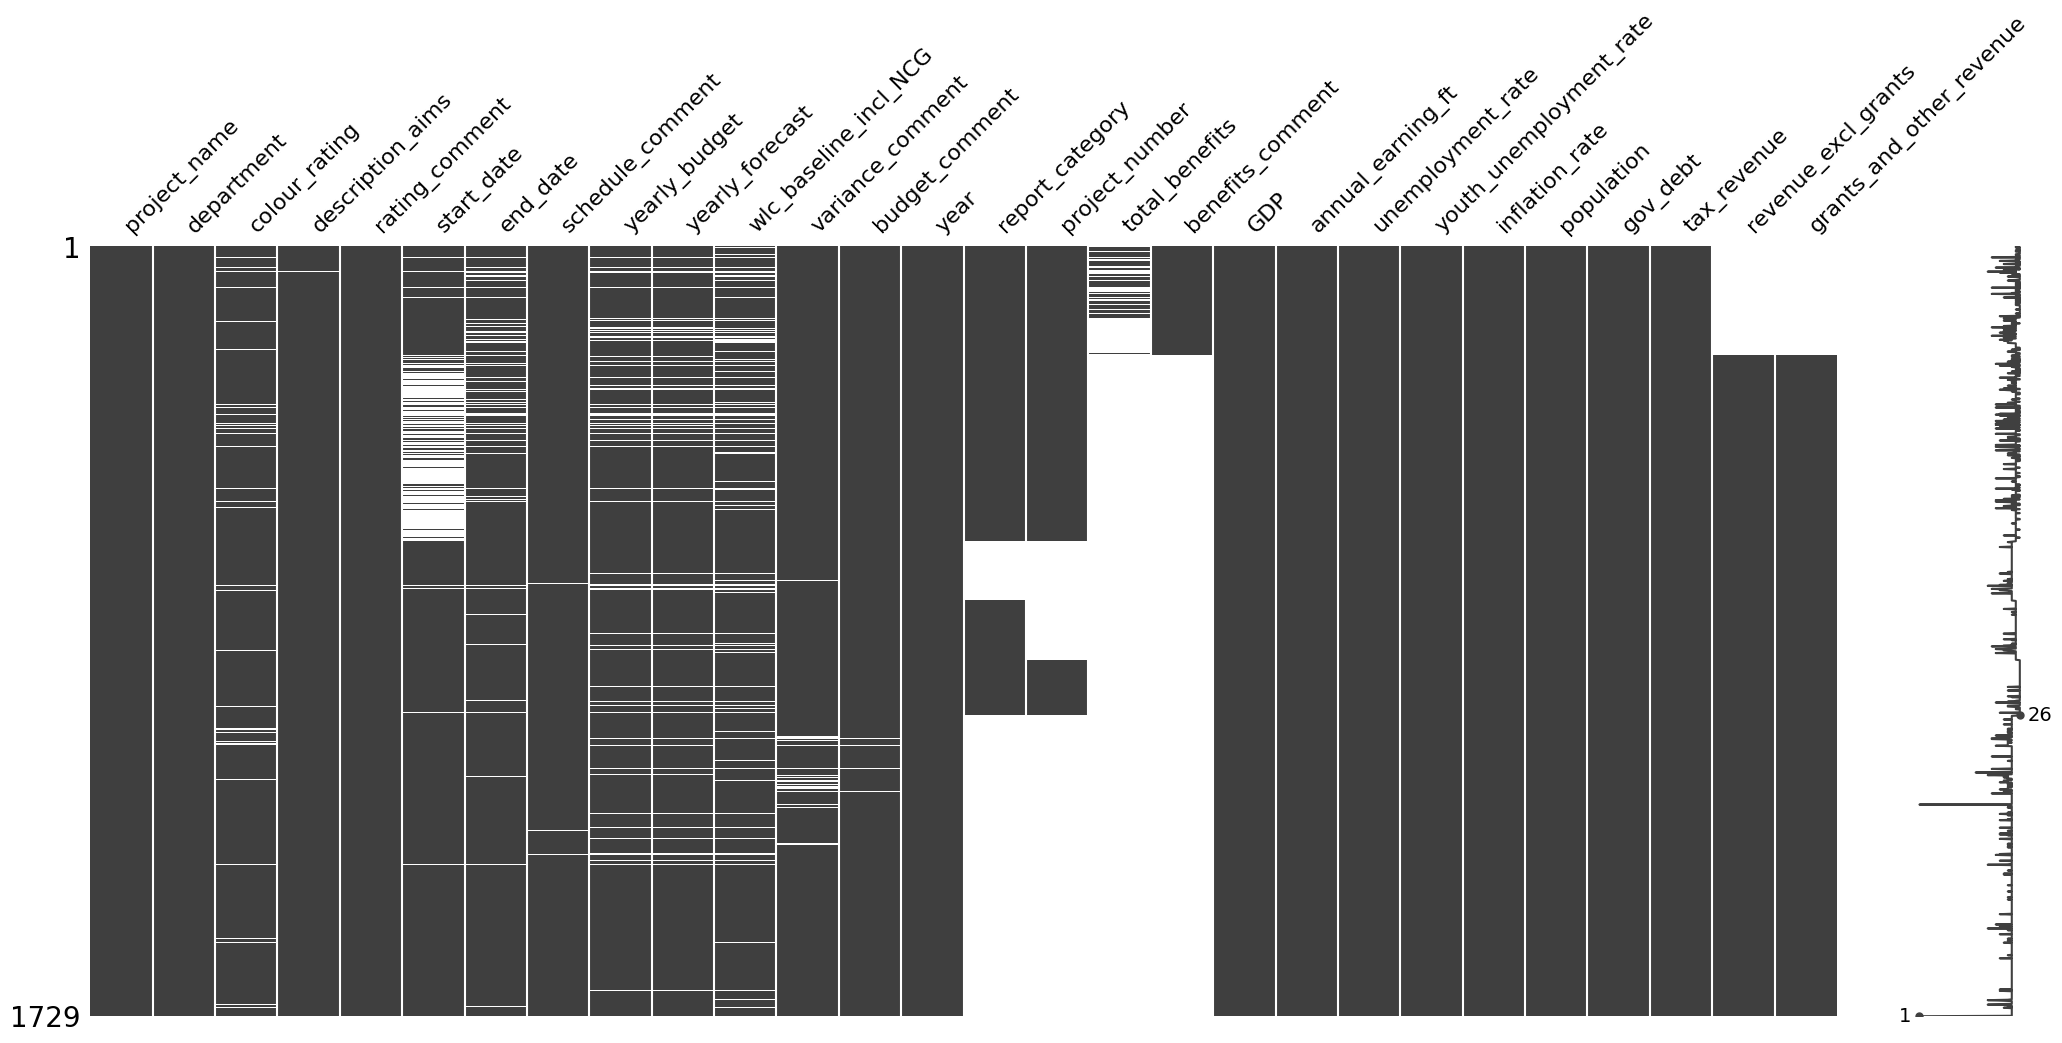

In [153]:
msn.matrix(df)

In [157]:
df["colour_rating"] = df["colour_rating"].str.lower()

# Drop rows where 'project_name' contains 'Unnamed:' followed by other characters
df = df[~df['project_name'].str.contains(r'Unnamed:.*', na=False)]

# Optionally, reset the index of the cleaned DataFrame
df = df.reset_index(drop=True)

In [158]:
latest_start_dates = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'start_date'])

In [159]:

for index, row in df.iterrows():
    latest_start_date = latest_start_dates[row['project_name']]
    if pd.isna(row['start_date']) and pd.notna(latest_start_date):
        df.at[index, 'start_date'] = latest_start_date

<Axes: >

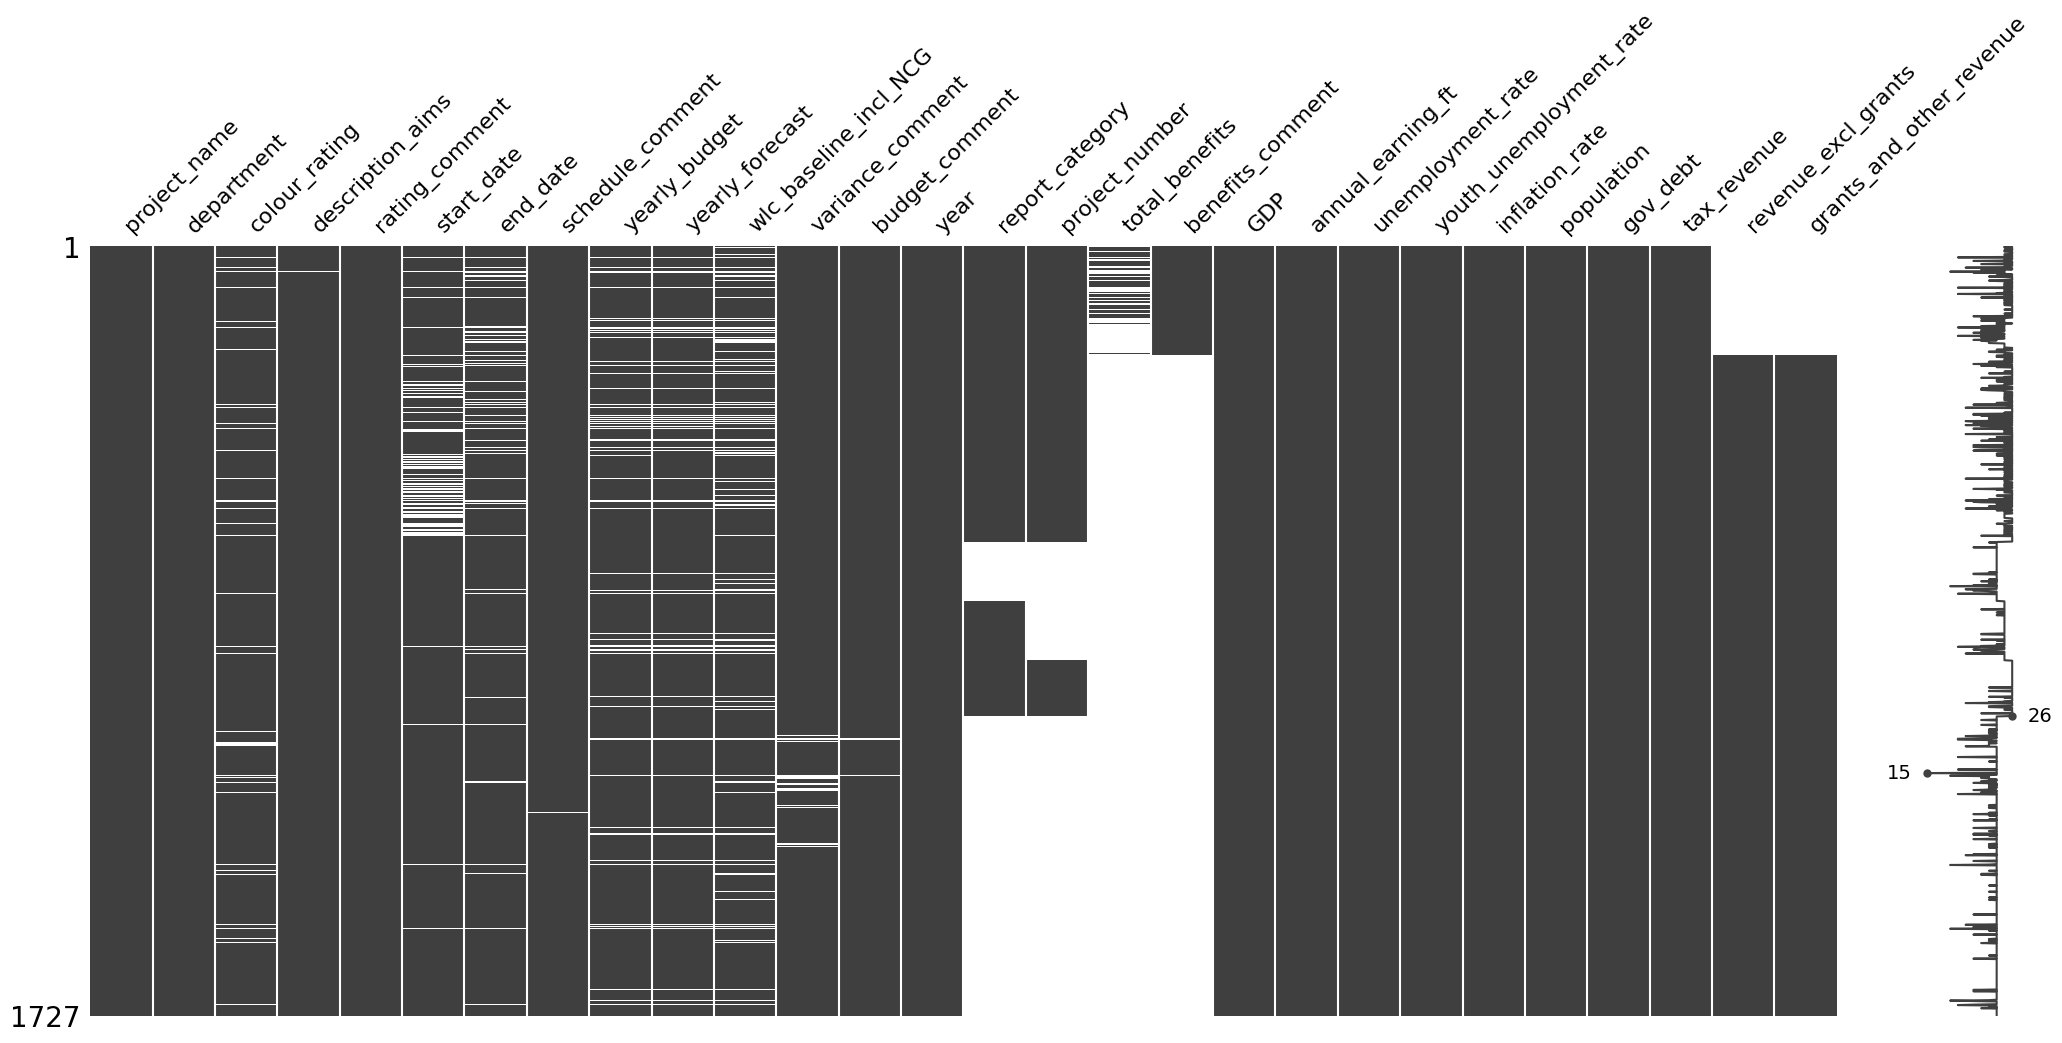

In [160]:
msn.matrix(df)

In [161]:
latest_benefits = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'total_benefits'])

for index, row in df.iterrows():
    latest_benefit = latest_benefits[row['project_name']]
    if pd.isna(row['total_benefits']) and pd.notna(latest_benefit):
        df.at[index, 'total_benefits'] = latest_benefit

<Axes: >

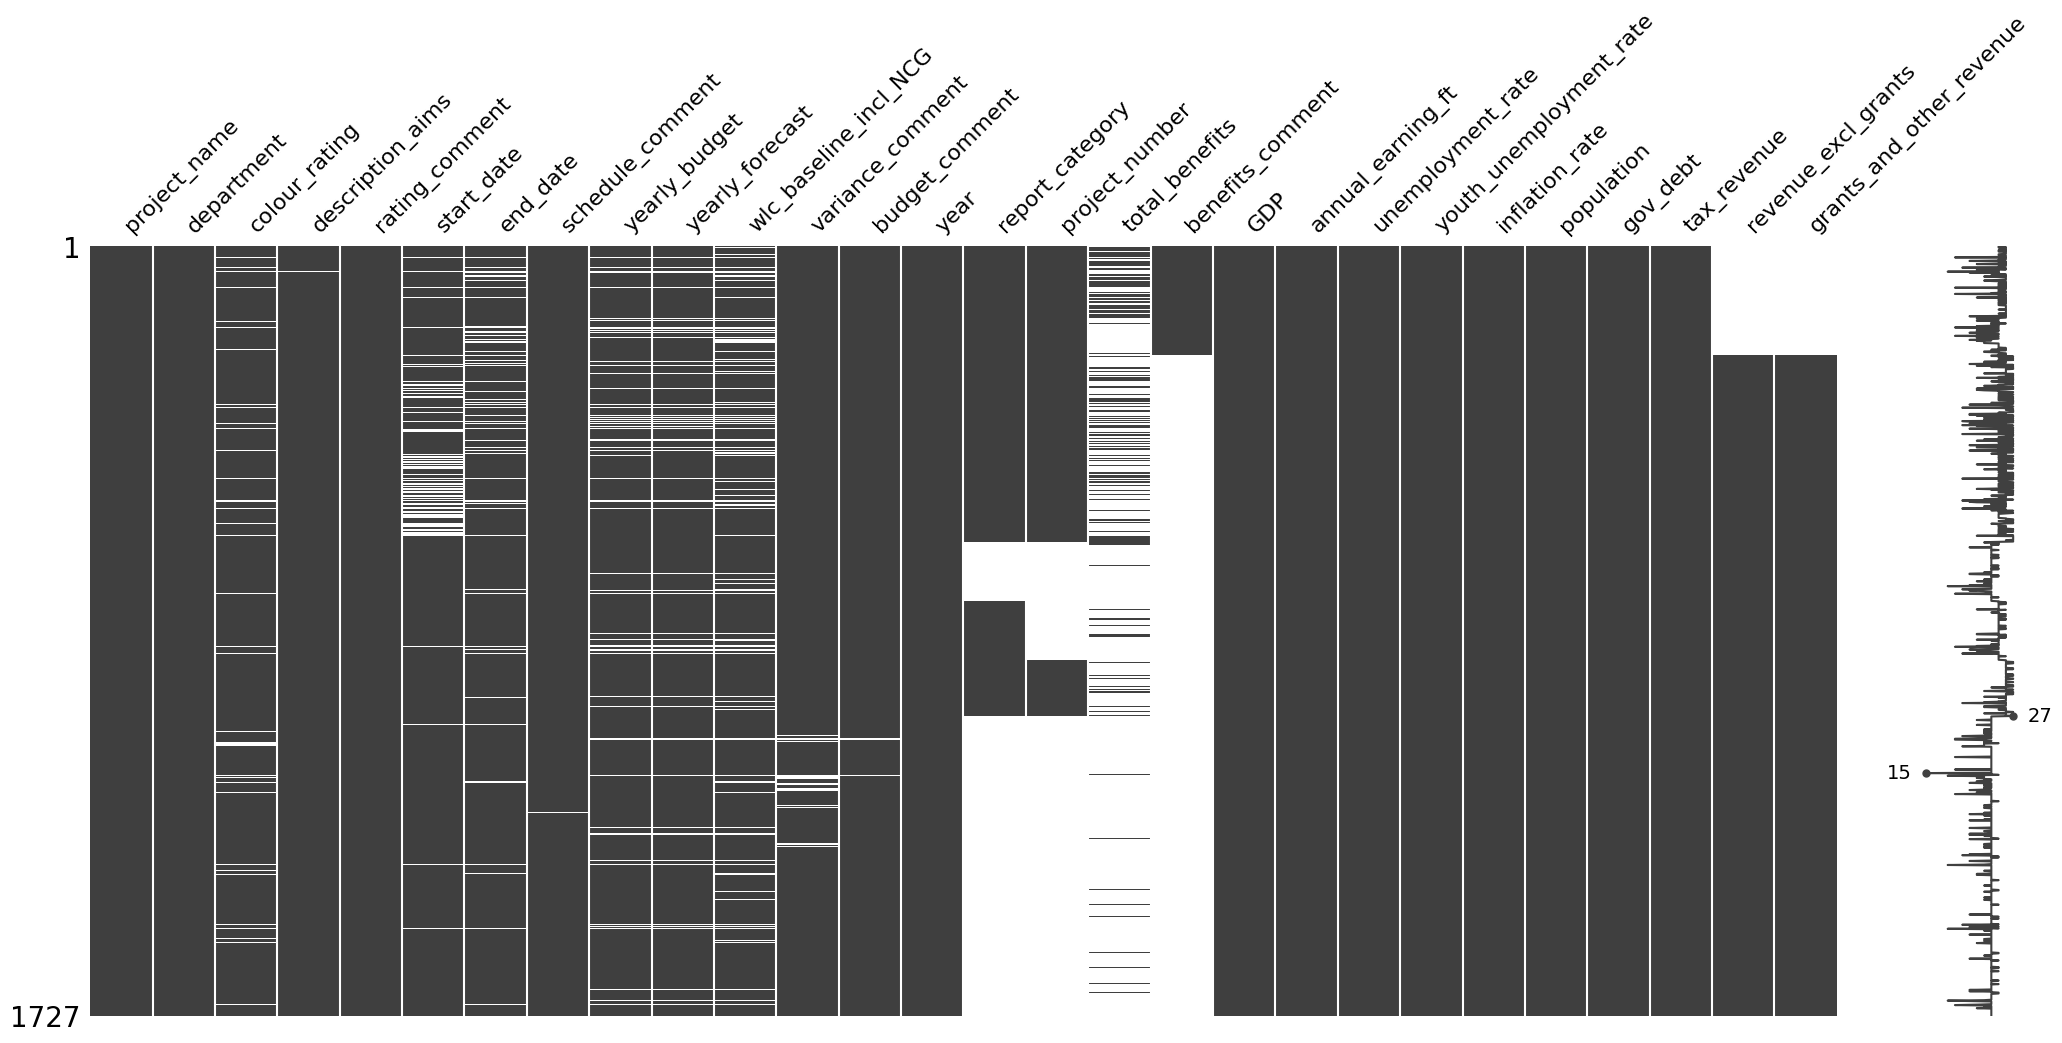

In [162]:
msn.matrix(df)

In [163]:
latest_categories = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'report_category'])

for index, row in df.iterrows():
    latest_category = latest_categories[row['project_name']]
    if pd.isna(row['report_category']) and pd.notna(latest_category):
        df.at[index, 'report_category'] = latest_category

<Axes: >

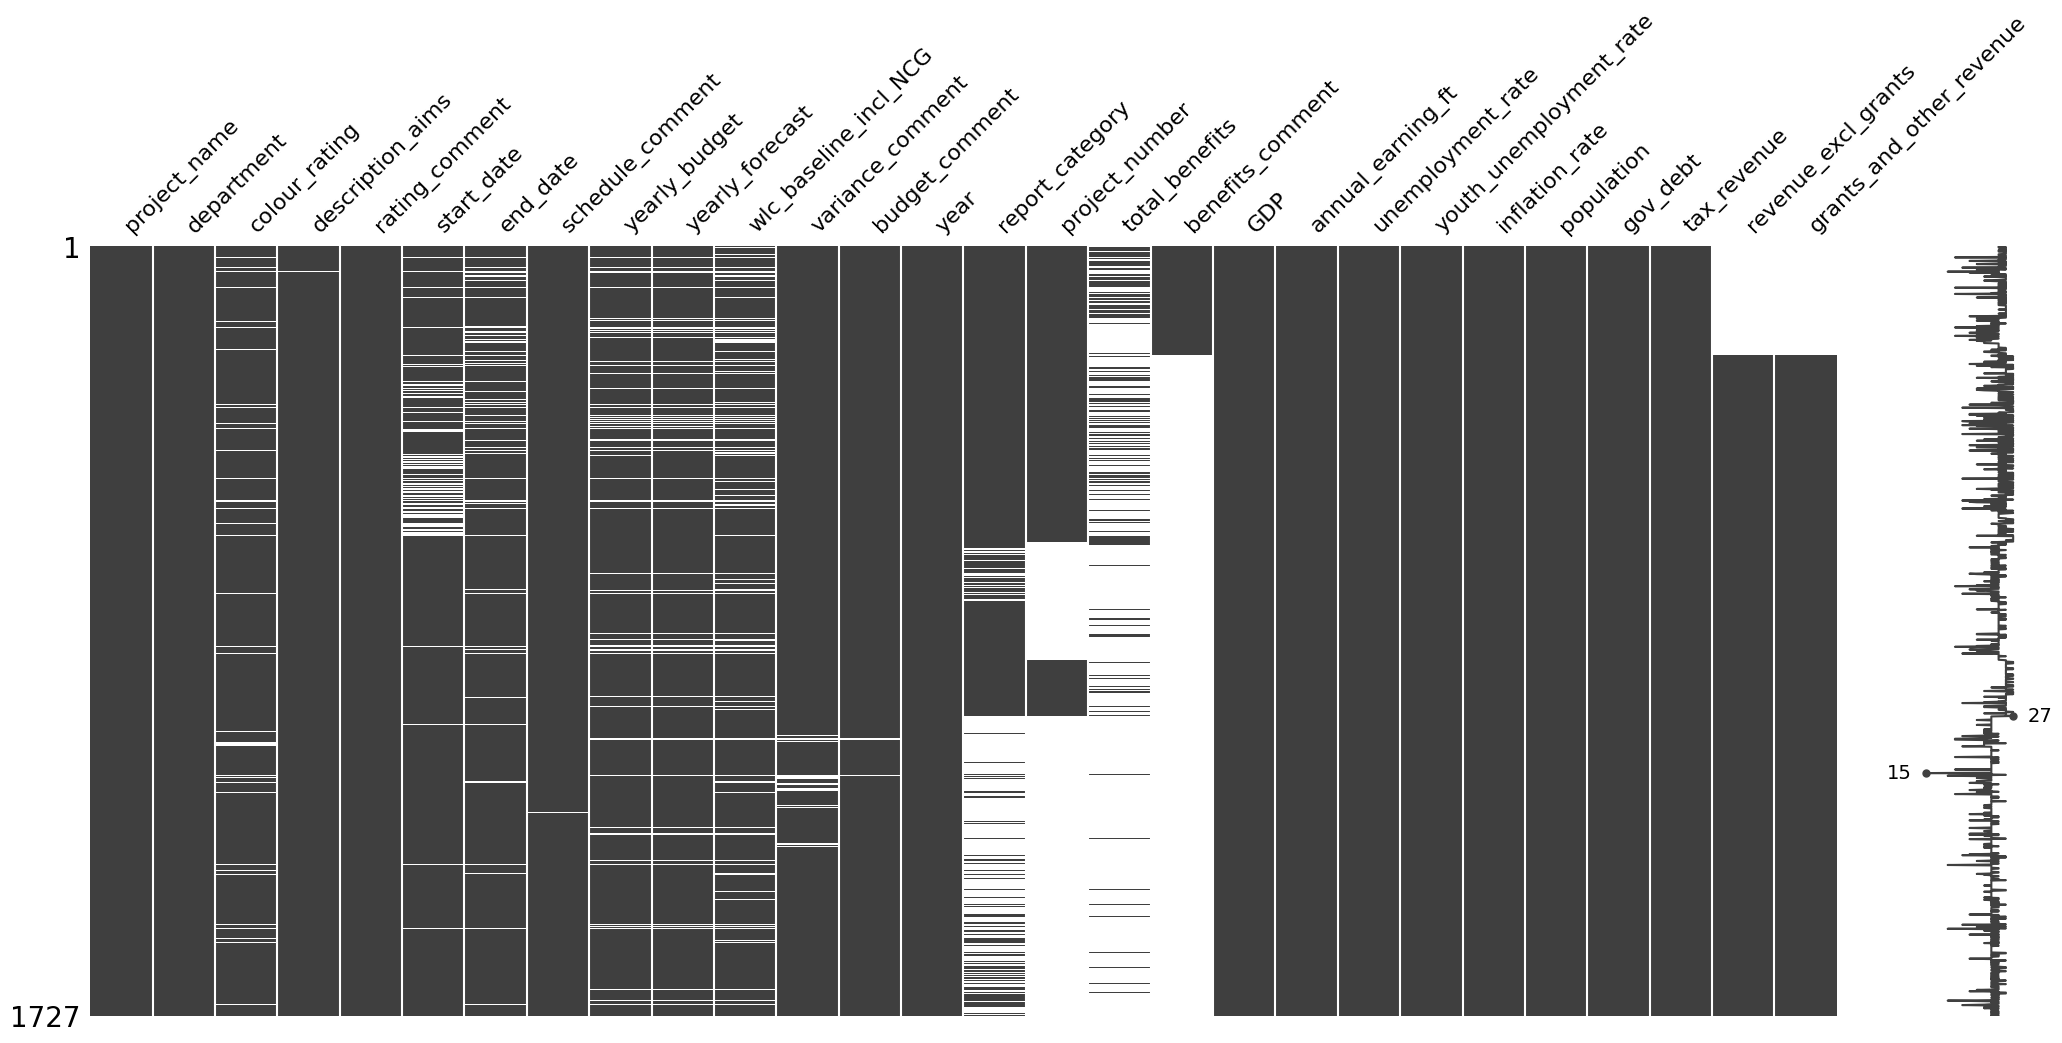

In [164]:
msn.matrix(df)

In [165]:
latest_numbers = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'project_number'])

for index, row in df.iterrows():
    latest_number = latest_numbers[row['project_name']]
    if pd.isna(row['project_number']) and pd.notna(latest_number):
        df.at[index, 'project_number'] = latest_number

<Axes: >

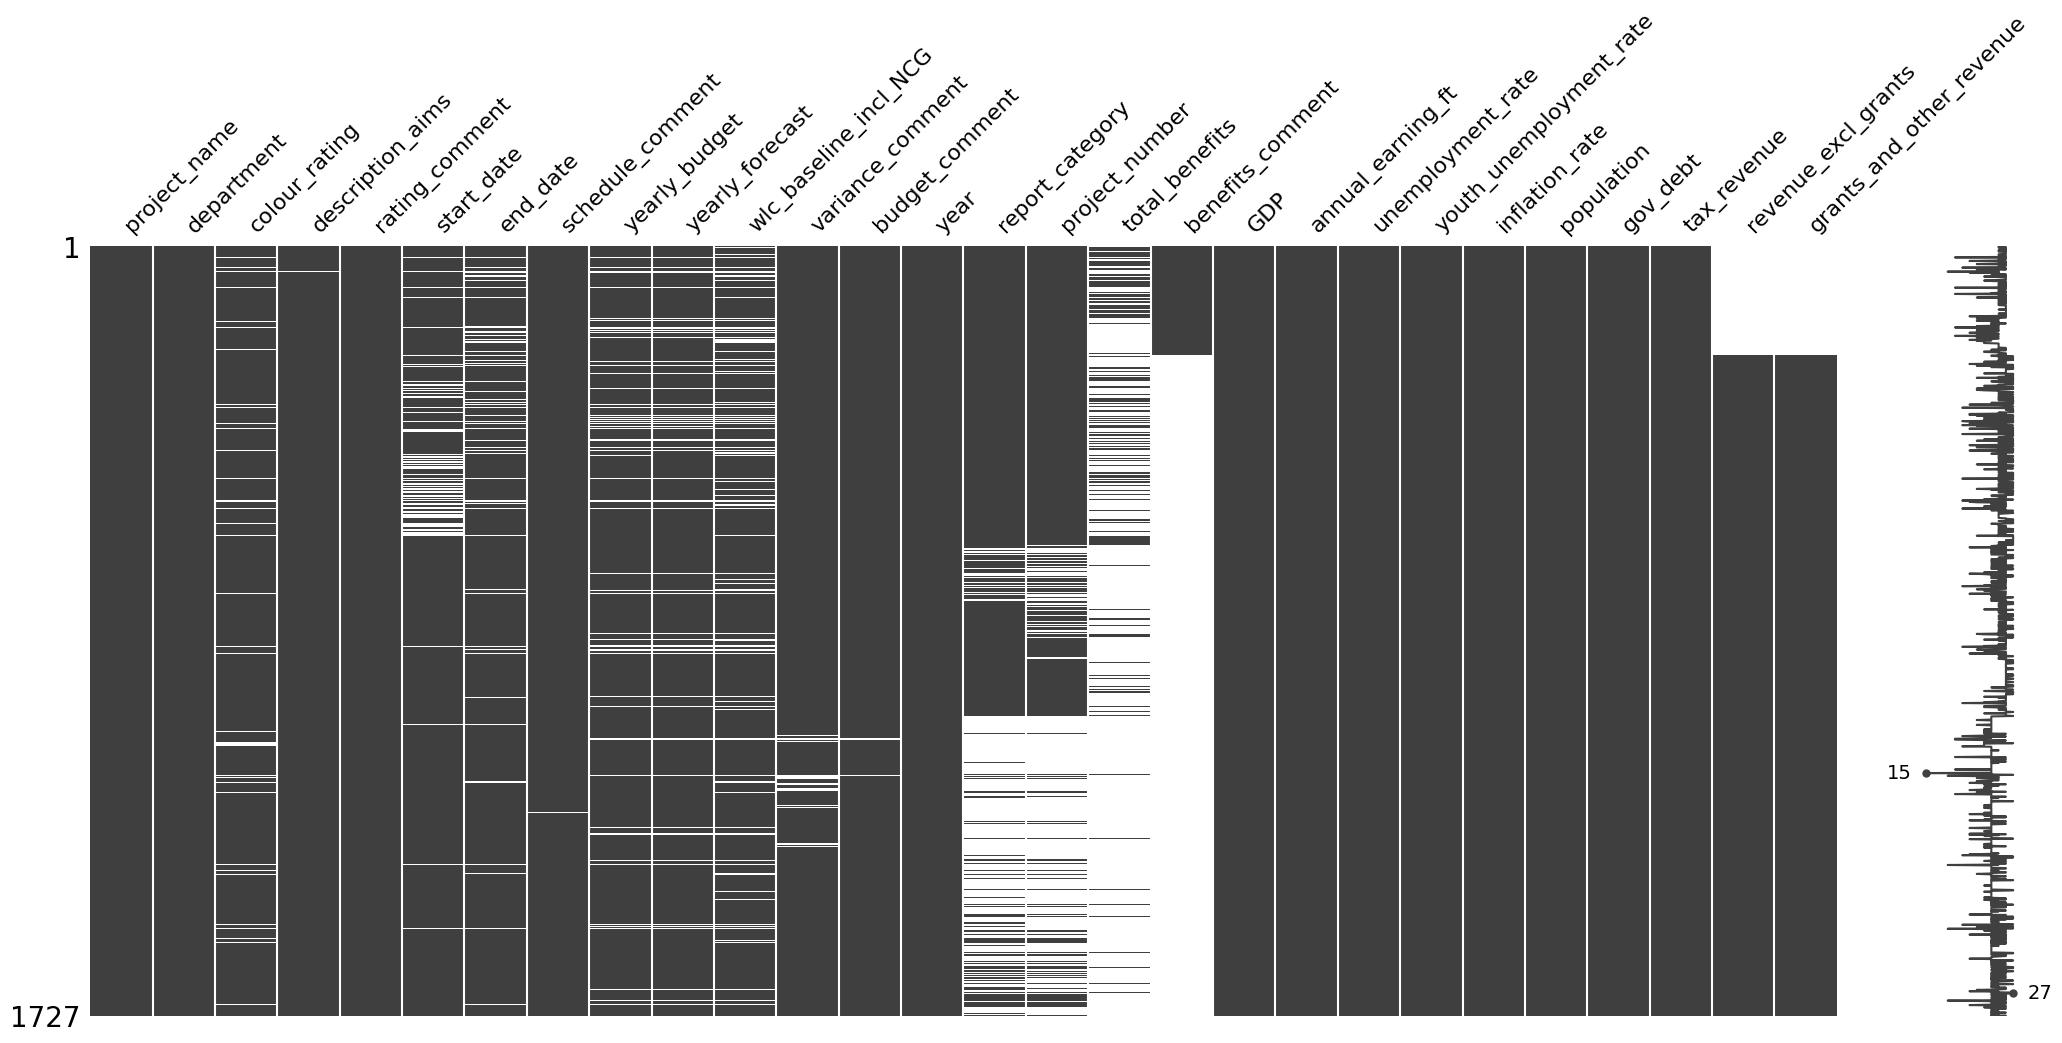

In [166]:
msn.matrix(df)

In [167]:
df.to_pickle('ready_for_EDA.pkl')